In [1]:
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

# adiciona a pasta src ao sys.path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# Importa o script paths de utils para geracão de caminhos absolutos
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="pastel",
    context="notebook"
)


In [2]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)

### Category - Id equivalence tables:

#### Continents:

In [3]:
arrivals_dataset.continent_table

,continent,continent_id
0,africa,1
1,america_central_e_caribe,2
2,america_do_norte,3
3,america_do_sul,4
4,asia,5
5,europa,6
6,oceania,7
7,continente_nao_especificado,8


#### Entry routes

In [4]:
arrivals_dataset.entry_route_table

,entry_route,entry_route_id
0,terrestre,2
1,fluvial,4
2,aereo,1
3,maritimo,3


#### States

In [5]:
arrivals_dataset.state_table

,state,state_id
0,acre,1
1,amapa,3
2,amazonas,4
3,bahia,5
4,ceara,6
5,distrito_federal,7
6,mato_grosso_do_sul,12
7,minas_gerais,13
8,para,14
9,parana,16


In [6]:
df =  arrivals_dataset.get_data_without_missing_values()
df.head()

,continent,continent_id,country,country_id,state,state_id,entry_route,entry_route_id,year,month,month_id,arrivals,file_index,date
0,africa,1,africa_do_sul,2,acre,1,terrestre,2,2015,janeiro,1,2.0,file_0,2015-01-01
1,africa,1,angola,6,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
2,africa,1,cabo_verde,35,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
3,africa,1,egito,60,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
4,africa,1,gana,77,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01


Our scope of analysis is Rio de Janeiro, so we'll filter only that state. Also, our aggregation categories are date, continent and entry route.

In [7]:
def process_df(df:pd.DataFrame, state:str, agg_cols:list, value_cols:list, agg_func:Callable) -> pd.DataFrame:
    df = df.copy()

    # Filter Rio de Janeiro
    df = df.loc[df["state"] == state, :]

    # Group by desired columns
    return df.groupby(agg_cols)[value_cols].agg(agg_func).reset_index()


In [25]:
df_rj = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id", "entry_route","entry_route_id", "year", "month", "month_id"], value_cols="arrivals", agg_func=np.sum)

/tmp/ipykernel_104583/2703529039.py:8: FutureWarning: The provided callable <function sum at 0x7845a4329440> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  return df.groupby(agg_cols)[value_cols].agg(agg_func).reset_index()


In [26]:
df_rj

,date,continent,continent_id,entry_route,entry_route_id,year,month,month_id,arrivals
0,2000-01-01,africa,1,aereo,1,2000,janeiro,1,1598.0
1,2000-01-01,africa,1,maritimo,3,2000,janeiro,1,69.0
2,2000-01-01,america_central_e_caribe,2,aereo,1,2000,janeiro,1,359.0
3,2000-01-01,america_central_e_caribe,2,maritimo,3,2000,janeiro,1,90.0
4,2000-01-01,america_do_norte,3,aereo,1,2000,janeiro,1,19924.0
...,...,...,...,...,...,...,...,...,...
4174,2024-12-01,asia,5,maritimo,3,2024,dezembro,12,103.0
4175,2024-12-01,europa,6,aereo,1,2024,dezembro,12,39697.0
4176,2024-12-01,europa,6,maritimo,3,2024,dezembro,12,284.0
4177,2024-12-01,oceania,7,aereo,1,2024,dezembro,12,1621.0


In [27]:

# Adjusting schema
df_rj["entry_route_id"] = df_rj["entry_route_id"].astype("category")
df_rj["continent_id"] = df_rj["continent_id"].astype("category")
df_rj["arrivals"] = df_rj["arrivals"].astype("Int64")
df_rj["month"] = pd.Categorical(
    df_rj["month"],
    df_rj["month"].unique().tolist(),
    ordered=True
    )



In [28]:
df_rj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4179 entries, 0 to 4178
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            4179 non-null   datetime64[ns]
 1   continent       4179 non-null   object        
 2   continent_id    4179 non-null   category      
 3   entry_route     4179 non-null   object        
 4   entry_route_id  4179 non-null   category      
 5   year            4179 non-null   int64         
 6   month           4179 non-null   category      
 7   month_id        4179 non-null   int64         
 8   arrivals        4179 non-null   Int64         
dtypes: Int64(1), category(3), datetime64[ns](1), int64(2), object(2)
memory usage: 213.2+ KB


We'll also instantiate an object of class Plotter in order to make plots for the EDA.

In [29]:
plotter = Plotter()

## Exploratory Data Analysis

* Arrivals time series

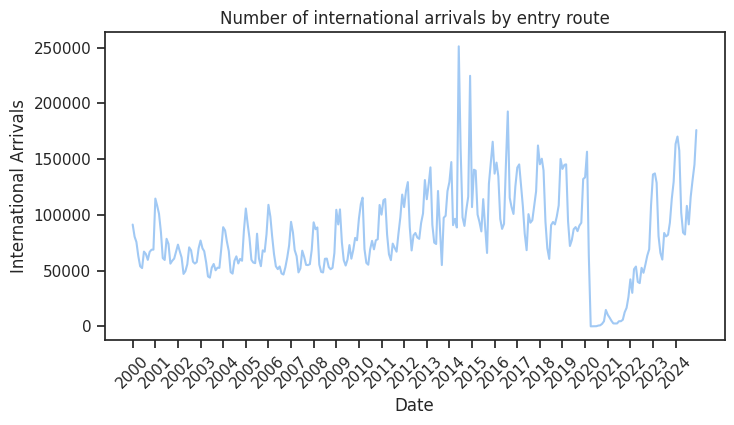

In [30]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Number of international arrivals by entry route"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

Clearly, between 2020 and 2021 tourism died.

* Time series behaviour by month since 2018 (excluding 2020 and 2021 because of covid)

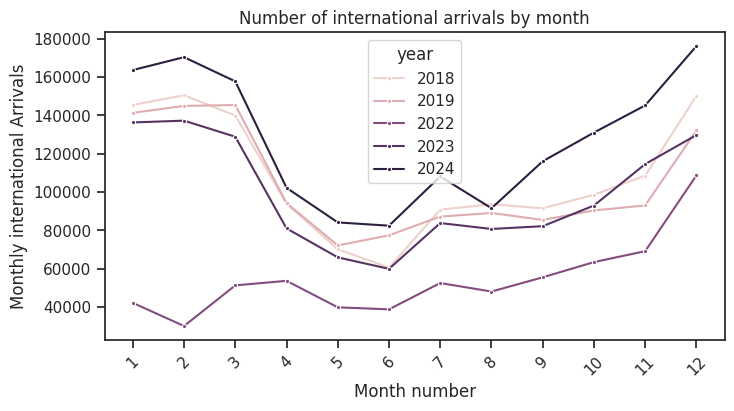

In [31]:
fig, ax = plotter.plot(
    data=df_rj[df_rj["year"].isin([2018, 2019, 2022, 2023, 2024])],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    x_label="Month number",
    y_label = "Monthly international Arrivals",
    title="Number of international arrivals by month",
    marker="."
    )

ax.tick_params(axis="x", rotation=45)
ax.set_xticks(np.arange(1, 13,1))

plt.show()

Looking at the time series of each year it is possible to notice that by 2022 international arrivals were still significantly lower than pre-covid. Also, it is clear that, on that year, the seasonal changes were still different than what is perceived historical patterns.

That said, it is also clear that since 2023 the seasonal variations show similar patterns noticed on pre-covid years.

* International arrivals by entry route

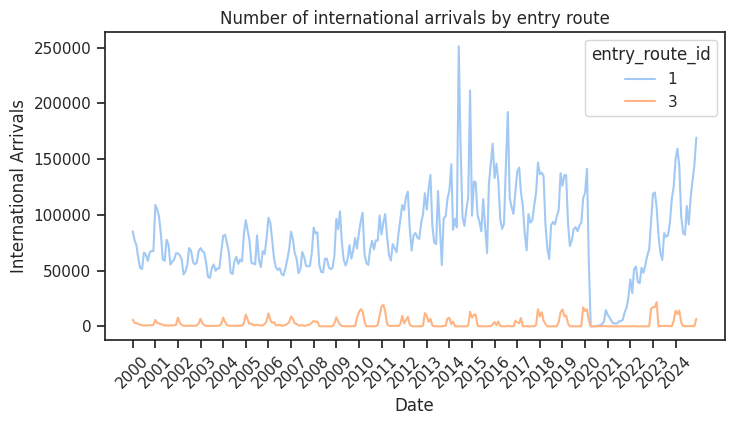

In [32]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    hue="entry_route_id",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Number of international arrivals by entry route"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

It's easy to spot that the tourism almost ceased to exist between 2020 and 2022 because of the COVID-19 pandemic. Therefore, in order to build a predictive model, we'll need to do some workaround in order to deal with that period of time.

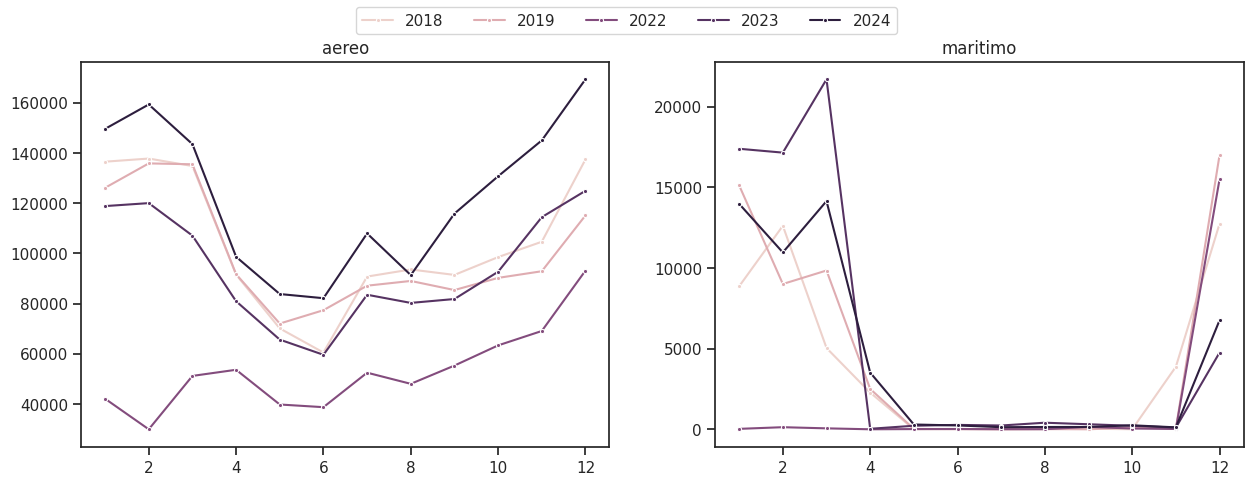

In [ ]:
n_entry_routes = df_rj["entry_route"].nunique()

fig, axs = plt.subplots(1, n_entry_routes,sharex=True, figsize=(15, 5))

temp_df = df_rj[df_rj["year"].isin([2018, 2019, 2022, 2023, 2024])]

for i, entry_route in enumerate(df_rj["entry_route"].unique()):
    entry_route_df = temp_df.loc[temp_df["entry_route"] == entry_route, :]
    _ax = plotter.plot(
    data=entry_route_df,
    ax=axs[i],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    # y_label = "Monthly international Arrivals",
    marker=".",
    title=entry_route
    )

    # remove a legenda local
    if i < n_entry_routes:
        axs[i].get_legend().remove()

# cria uma legenda global com base no último ax
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(labels))

plt.show()

There are almost no sea arrivals from months 5 to 11.

* Internationals arrivals by continent

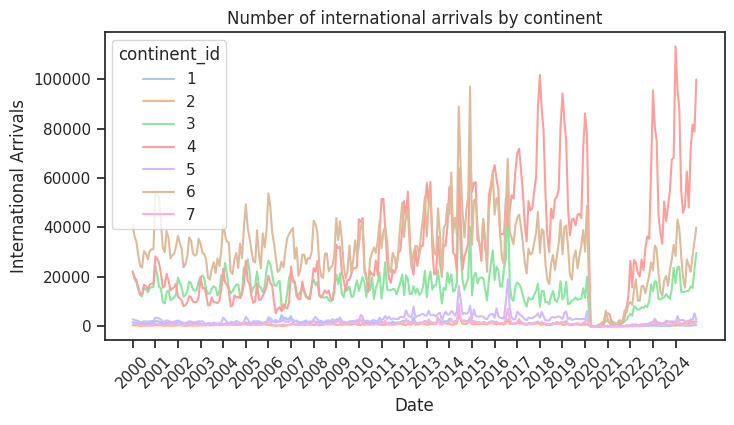

In [33]:
fig, ax = plotter.plot(
    data=df_rj,
    plot_name="lineplot",
    x="date",
    y="arrivals",
    hue="continent_id",
    estimator="sum",
    errorbar=None,
    x_label="Date",
    y_label = "International Arrivals",
    title="Number of international arrivals by continent"
    )

years = pd.date_range(start=df_rj["date"].min(), end=df_rj["date"].max(), freq="YS")
ax.set_xticks(years)             # posições no eixo (datetime)
ax.set_xticklabels(years.year)   # rótulos como ano
ax.tick_params(axis="x", rotation=45)

plt.show()

It is possible to note that, at least since the pandemic, most of the tourists are from latin america, followed by europeans and north americans.

* Month seasonality by continent

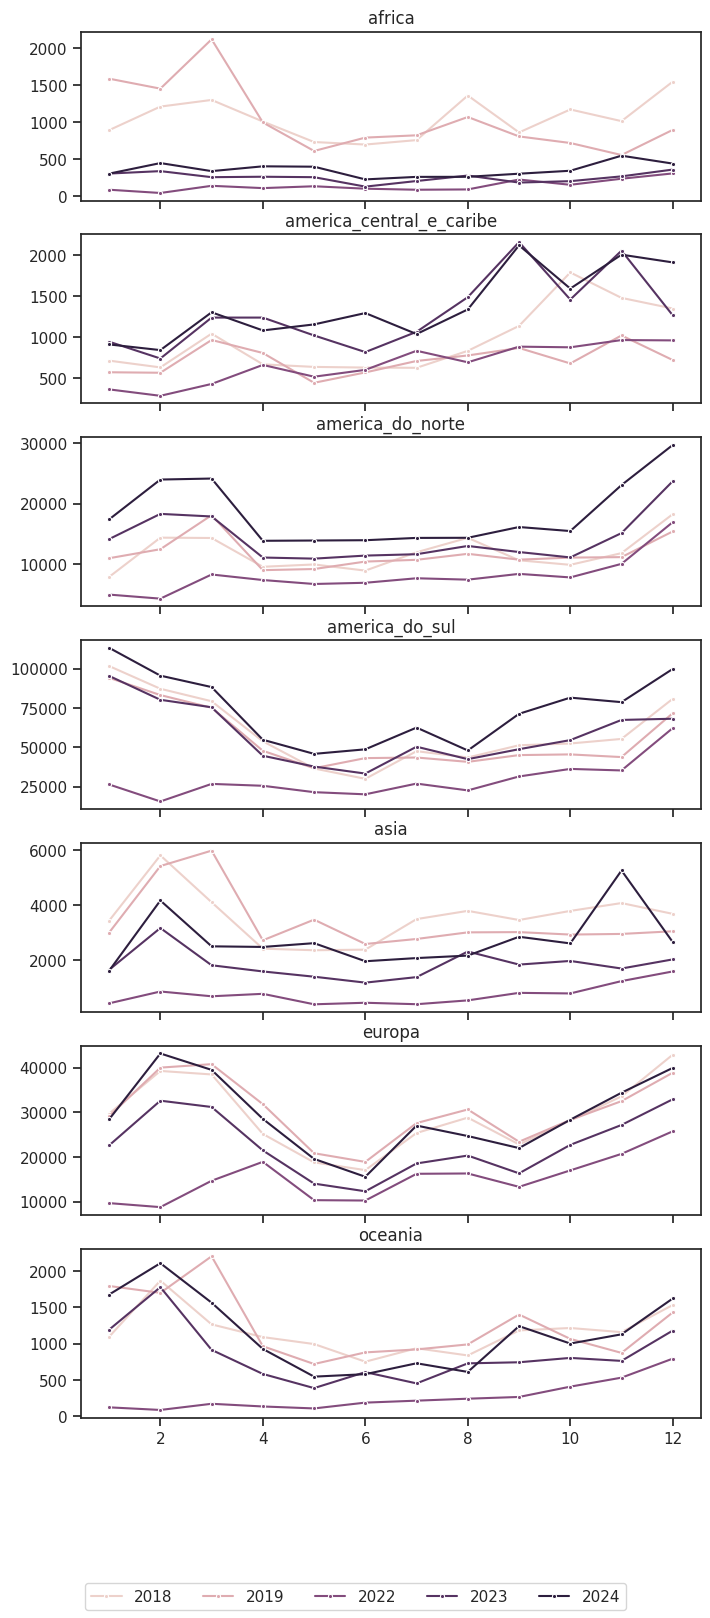

In [ ]:
n_continents = df_rj["continent_id"].nunique()

fig, axs = plt.subplots(n_continents, 1, sharex=True, figsize=(8, 18))

temp_df = df_rj[df_rj["year"].isin([2018, 2019, 2022, 2023, 2024])]

for i, continent in enumerate(df_rj["continent"].unique()):
    continent_df = temp_df.loc[temp_df["continent"] == continent, :]
    _ax = plotter.plot(
    data=continent_df,
    ax=axs[i],
    plot_name="lineplot",
    x="month_id",
    y="arrivals",
    hue="year",
    estimator="sum",
    errorbar=None,
    # y_label = "Monthly international Arrivals",
    marker=".",
    title=continent
    )

    # remove a legenda local
    if i < n_continents:
        axs[i].get_legend().remove()

# cria uma legenda global com base no último ax
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels))

plt.show()